# 안개 발생 진단 분류 모델 생성

## 1. 데이터 설명

## 2. 데이터 불러오기

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pickle
import optuna
from optuna.samplers import TPESampler

from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
from catboost import Pool, CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import CategoricalNB

from sklearn.model_selection import train_test_split

# from sklearn.preprocessing import TargetEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer


import warnings
warnings.filterwarnings(action='ignore')

c:\Users\aryij\anaconda3\envs\weather2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# def get_colab_path(train_dataset_name, test_dataset_name):

#     fog_folder = "drive/MyDrive/weather_bigdata/fog_data"
#     os.makedirs(fog_folder, exist_ok=True)

#     # train/test 데이터셋 경로 잡아준다
#     train_path = os.path.join(os.getcwd(), fog_folder, train_dataset_name)
#     test_path = os.path.join(os.getcwd(), fog_folder, test_dataset_name)

#     return train_path, test_path

In [3]:
def get_local_path(train_dataset_name, val_dataset_name, test_dataset_name):

    # 작업 디렉토리 origin_dir에 선언
    origin_dir = os.getcwd()

    # ".." : 상위 디렉토리로 이동
    os.chdir("..")

    # 상위 디렉토리에 fog_data가 없다면 fog_data 폴더 생성
    # (이미 폴더 있어도 exist_ok=True면 넘어감)
    os.makedirs("fog_data", exist_ok=True)

    # train/test 데이터셋 경로 잡아준다
    train_path = os.path.join(os.getcwd(), "fog_data", train_dataset_name)
    val_path = os.path.join(os.getcwd(), "fog_data", val_dataset_name)
    test_path = os.path.join(os.getcwd(), "fog_data", test_dataset_name)

    # 운영체제가 윈도우일 경우, "\\"를 "/"로 바꿔줘야 한다
    if os.name == "nt":
        train_path = train_path.replace("\\", "/")
        val_path = val_path.replace("\\", "/")
        test_path = test_path.replace("\\", "/")

    # origin_dir로 경로 다시 변경 (초기화)
    os.chdir(origin_dir)

    return train_path, val_path, test_path

In [4]:
# train_path, test_path = get_colab_path("fog_train_mod.csv", "fog_test_mod.csv")
# train_path, val_path, test_path = get_local_path("fog_train_mod.csv", "fog_val_mod.csv", "fog_test_mod.csv")

# 전처리 중간에 nan 제거해주고 이상치 제거한 train_df
train_path, val_path, test_path = get_local_path("fog_train_no_nan.csv", "fog_val_mod.csv", "fog_test_mod.csv")


In [5]:
train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)

In [6]:
train_df["class"].value_counts()

class
4.0    2187331
2.0       8928
3.0       8861
1.0       5836
Name: count, dtype: int64

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2210956 entries, 0 to 2210955
Data columns (total 18 columns):
 #   Column       Dtype  
---  ------       -----  
 0   year         object 
 1   month        int64  
 2   time         int64  
 3   stn_id       object 
 4   ws10_deg     float64
 5   ws10_ms      float64
 6   ta           float64
 7   re           float64
 8   hm           float64
 9   sun10        float64
 10  ts           float64
 11  vis1         int64  
 12  class        float64
 13  is_fog       int64  
 14  dew_point    float64
 15  dew_reached  int64  
 16  temp_diff    float64
 17  ws10_dir     object 
dtypes: float64(10), int64(5), object(3)
memory usage: 303.6+ MB


In [8]:
# 강수량 (re) 컬럼이 float라 integer로 변환
train_df["re"] = train_df["re"].astype("int")
val_df["re"] = val_df["re"].astype("int")
test_df["re"] = test_df["re"].astype("int")

In [9]:
train_df.head(3)

,year,month,time,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1,class,is_fog,dew_point,dew_reached,temp_diff,ws10_dir
0,J,4,15,B,112.4,2.2,10.3,0,59.3,0.14,13.8,20000,4.0,0,2.959540,0,-3.5,E
1,I,4,9,B,273.6,4.8,10.1,0,54.4,0.31,18.3,20000,4.0,0,1.603905,0,-8.2,W
2,I,3,10,D,158.2,3.1,18.1,0,47.0,0.22,20.1,50100,4.0,0,6.970513,0,-2.0,S


In [10]:
val_df.head(3)

,year,month,time,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1,class,is_fog,dew_point,dew_reached,temp_diff,ws10_dir
0,I,3,8,B,283.0,3.1,4.2,0,63.9,0.08,5.7,8888,4.0,0,-1.810578,0,-1.5,W
1,I,2,7,D,305.7,5.0,-0.1,0,93.5,0.00,0.2,4687,4.0,0,-0.988863,0,-0.3,NW
2,I,4,3,A,68.9,0.1,6.7,0,46.2,0.00,4.2,15715,4.0,0,-3.687619,0,2.5,E


In [11]:
test_df.head(3)

,year,month,time,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,class,is_fog,dew_point,dew_reached,temp_diff,ws10_dir
0,L,1,0,A,329.5,0.6,-2.5,0,87.5,0.0,-1.6,NaN,1,-4.223642,0,-0.9,NW
1,L,1,0,A,321.8,1.2,-2.5,0,88.2,0.0,-1.6,NaN,1,-4.121508,0,-0.9,NW
2,L,1,0,A,0.4,0.4,-2.5,0,88.6,0.0,-1.7,NaN,1,-4.063468,0,-0.8,N


## 3. 모델링

### 3-1. 데이터 분리

In [12]:
# # Target 컬럼 : class
# target = "class"

# # 모델 생성시 사용할 컬럼 지정
# used_cols = ["month", "time", "stn_id", "ta", "ts", "temp_diff", "hm", 
#              "re", "ws10_deg", "ws10_ms", "sun10", "dew_reached"]

# # train_df의 컬럼들 중 target (class) 제외한 컬럼들 X에 선언
# X = train_df[used_cols]
# y = train_df[target]

In [61]:
# target 컬럼
target = "class"

# # 모델 생성시 사용할 컬럼 지정
used_cols = ["month", "time", "stn_id", "ta", "ts", "temp_diff", "hm", 
             "re", "ws10_deg", "ws10_ms", "sun10", "dew_reached"]

# 8방위 사용
# used_cols = ["month", "time", "stn_id", "ta", "ts", "temp_diff", "hm", 
#              "re", "ws10_dir", "ws10_ms", "sun10", "dew_reached"]


# used_cols = ["time", "stn_id", "temp_diff", "hm", 
#              "re", "ws10_ms", "dew_reached"]

# used_cols = ["time", "stn_id", "temp_diff", "hm", "month",
#              "re", "ws10_ms", "dew_reached"]

# used_cols = ["month", "time", "stn_id", "ta", "ts", "temp_diff", "hm",
#              "ws10_ms"]

X_train = train_df[used_cols]
y_train = train_df[target]

X_val = val_df[used_cols]
y_val = val_df[target]

X_test = test_df[used_cols]

In [62]:
y_train.value_counts()

class
4.0    2187331
2.0       8928
3.0       8861
1.0       5836
Name: count, dtype: int64

In [63]:
y_val.value_counts()

class
4.0    775452
3.0      3045
2.0      3022
1.0      1967
Name: count, dtype: int64

#### 3-1-1. Train, Validation 데이터 분리

In [45]:
# X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, train_size=0.75, stratify=y)
# X_train.shape, X_val.shape, y_train.shape, y_val.shape

In [46]:
# X_test = test_df[used_cols]
# X_test.shape

In [64]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape, X_test.shape

((2210956, 12), (783486, 12), (2210956,), (783486,), (262800, 12))

In [65]:
X_train.head()

,month,time,stn_id,ta,ts,temp_diff,hm,re,ws10_deg,ws10_ms,sun10,dew_reached
0,4,15,B,10.3,13.8,-3.5,59.3,0,112.4,2.2,0.14,0
1,4,9,B,10.1,18.3,-8.2,54.4,0,273.6,4.8,0.31,0
2,3,10,D,18.1,20.1,-2.0,47.0,0,158.2,3.1,0.22,0
3,7,23,A,24.0,24.3,-0.3,81.8,0,238.0,0.9,0.00,0
4,1,0,D,-3.8,-3.0,-0.8,81.6,0,303.7,1.0,0.00,0


In [66]:
X_val.head(3)

,month,time,stn_id,ta,ts,temp_diff,hm,re,ws10_deg,ws10_ms,sun10,dew_reached
0,3,8,B,4.2,5.7,-1.5,63.9,0,283.0,3.1,0.08,0
1,2,7,D,-0.1,0.2,-0.3,93.5,0,305.7,5.0,0.00,0
2,4,3,A,6.7,4.2,2.5,46.2,0,68.9,0.1,0.00,0


### 3-2. CSI 지수 생성

In [67]:
# CSI 지수 함수 생성
def csi_index(y_true, y_pred):

    model_cm = confusion_matrix(y_true, y_pred)

    H = (model_cm[0][0] + model_cm[1][1] + model_cm[2][2])
    F = (model_cm[0][1] + model_cm[0][2] +
            model_cm[1][0] + model_cm[1][2] +
            model_cm[2][0] + model_cm[2][1] +
            model_cm[3][0] + model_cm[3][1] + model_cm[3][2])
    M = (model_cm[0][3] + model_cm[1][3] + model_cm[2][3])

    model_csi = H / (H + F + M)

    return model_csi

csi_scorer = make_scorer(csi_index, greater_is_better=True)

### 3-3. 인코딩

#### 3-3-1. Label Encoding

In [68]:
# Label Encoding 적용을 위해 train, val, test 데이터 copy()
X_train_labeled = X_train.copy()
X_val_labeled = X_val.copy()
X_test_labeled = X_test.copy()

In [69]:
# stn_id를 각각 1 ~ 5로 정한 딕셔너리 생성
stn_id_map = {"A" : 1,
              "B" : 2,
              "C" : 3,
              "D" : 4,
              "E" : 5}

# stn_id_map을 바탕으로 stn_id 컬럼 mapping
X_train_labeled["stn_id"] = X_train_labeled["stn_id"].map(stn_id_map)
X_val_labeled["stn_id"] = X_val_labeled["stn_id"].map(stn_id_map)
X_test_labeled["stn_id"] = X_test_labeled["stn_id"].map(stn_id_map)

In [70]:
# # ws10_dir를 각각 1 ~ 5로 정한 딕셔너리 생성
# ws10_dir_map = {"N" : 1,
#               "NE" : 2,
#               "E" : 3,
#               "SE" : 4,
#               "S" : 5,
#               "SW" : 6,
#               "W" : 7,
#               "NW" : 8}

# # ws10_dir_map을 바탕으로 ws10_dir 컬럼 mapping
# X_train_labeled["ws10_dir"] = X_train_labeled["ws10_dir"].map(ws10_dir_map)
# X_val_labeled["ws10_dir"] = X_val_labeled["ws10_dir"].map(ws10_dir_map)
# X_test_labeled["ws10_dir"] = X_test_labeled["ws10_dir"].map(ws10_dir_map)

### 3-4. Baseline 모델 생성

In [71]:
# 의사결정나무 모델로 Baseline 모델 생성
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_labeled, y_train)

DecisionTreeClassifier(random_state=42)

In [72]:
def model_comparison(models, X_train, y_train, X_val, y_val, when="Before"):
    models_results = []

    for model_name, model in models:

        # 모델 생성 및 훈련
        # 트리 기반 모델들은 각 변수의 information gain을 기반으로 판단하기 때문에 굳이 스케일링 해줄 필요가 없다

        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        # 모델의 Accuracy, Precision, Recall, F1 score, CSI 지수 확인
        accuracy = accuracy_score(y_val, y_val_pred)
        precision = precision_score(y_val, y_val_pred, average="weighted")
        recall = recall_score(y_val, y_val_pred, average="weighted")
        f1_score_ = f1_score(y_val, y_val_pred, average="weighted")
        csi_index_ = csi_index(y_val, y_val_pred)
        # rootMeanSqLogErr = get_rmsle(y_val, y_val_pred)

        # 결과를 리스트에 저장
        models_results.append({"Model" : model_name,
                               "Accuracy" : np.round(accuracy, 4),
                               "Precision" : np.round(precision, 4),
                               "Recall" : np.round(recall, 4),
                               "F1 Score" : np.round(f1_score_, 4),
                               "CSI Index" : np.round(csi_index_, 4)
                               })

    # 결과 리스트를 DataFrame으로 변환
    models_df = pd.DataFrame(models_results)

    print(f"\n======== Models {when} Hyper Parameter Tuning ========\n")

    return models_df.sort_values(by=["CSI Index", "Accuracy", "F1 Score"],
                                 ascending=[False, True, False]
                                 ).reset_index(drop=True)


### 3-5. 하이퍼 파라미터 튜닝 전 모델 생성 (CatBoost)

In [73]:
models = [
    ("Decision Tree", DecisionTreeClassifier(random_state=42)),
    ("CatBoost", CatBoostClassifier(loss_function='MultiClass', verbose=0, task_type="GPU",random_state=42)),
    # ("Naive Bayes", GaussianNB()),
    # ("Random Forest", RandomForestClassifier(random_state=42))
]

In [74]:
model_comparison(models, X_train_labeled, y_train, X_val_labeled, y_val)


======== Models Before Hyper Parameter Tuning ========



,Model,Accuracy,Precision,Recall,F1 Score,CSI Index
0,Decision Tree,0.9874,0.9883,0.9874,0.9878,0.2220
1,CatBoost,0.9913,0.9883,0.9913,0.9887,0.1827


#### 3-5-2. 범주형 변수 인코딩 하지 않은 데이터셋 모델 생성 (CatBoost)

In [75]:
X_train_no_enc = X_train.copy()
X_val_no_enc = X_val.copy()

In [76]:
def model_comparison_cat(models, X_train, y_train, X_val, y_val, when="Before"):
    models_results = []

    for model_name, model in models:

        # 모델 생성 및 훈련
        # 트리 기반 모델들은 각 변수의 information gain을 기반으로 판단하기 때문에 굳이 스케일링 해줄 필요가 없다

        if model_name in ["CatBoost", "CatBoost_tuned"]:

            train_data = X_train_no_enc
            eval_data = X_val_no_enc

            # cat_features = ['month', 'stn_id', 're', 'dew_reached', "ws10_dir"]
            cat_features = ['month', 'stn_id', 're', 'dew_reached']
            # cat_features = ['stn_id', 're', 'dew_reached']
            # cat_features = ['month', 'stn_id', 're', 'dew_reached']
            # cat_features = ['month', 'stn_id']


            train_label = y_train
            eval_label = y_val

            train_dataset = Pool(data=train_data,
                                label=train_label,
                                cat_features=cat_features)

            eval_dataset = Pool(data=eval_data,
                                label=eval_label,
                                cat_features=cat_features)

            # Initialize CatBoostClassifier
            model = CatBoostClassifier(loss_function='MultiClass', 
                                            verbose=0, 
                                            task_type="GPU",
                                            devices="0",
                                            random_state=42)

            # 모델 생성 및 훈련
            model.fit(train_dataset)

            # Robust Scaling 거치지 않은 train 데이터를 바탕으로 예측
            # y_train_pred_cat = model.predict(X_train_no_enc)
            y_val_pred_cat = model.predict(eval_dataset)

            # 모델의 Accuracy, Precision, Recall, F1 score, CSI 지수 확인
            accuracy = accuracy_score(y_val, y_val_pred_cat)
            precision = precision_score(y_val, y_val_pred_cat, average="weighted")
            recall = recall_score(y_val, y_val_pred_cat, average="weighted")
            f1_score_ = f1_score(y_val, y_val_pred_cat, average="weighted")
            csi_index_ = csi_index(y_val, y_val_pred_cat)
            # rootMeanSqLogErr = get_rmsle(y_val, y_val_pred_cat)

            # 결과를 리스트에 저장
            models_results.append({"Model" : model_name,
                                "Accuracy" : np.round(accuracy, 4),
                                "Precision" : np.round(precision, 4),
                                "Recall" : np.round(recall, 4),
                                "F1 Score" : np.round(f1_score_, 4),
                                "CSI Index" : np.round(csi_index_, 4)
                                })

        else:
            model.fit(X_train, y_train)

            y_train_pred = model.predict(X_train)
            y_val_pred = model.predict(X_val)

            # 모델의 Accuracy, Precision, Recall, F1 score, CSI 지수 확인
            accuracy = accuracy_score(y_val, y_val_pred)
            precision = precision_score(y_val, y_val_pred, average="weighted")
            recall = recall_score(y_val, y_val_pred, average="weighted")
            f1_score_ = f1_score(y_val, y_val_pred, average="weighted")
            csi_index_ = csi_index(y_val, y_val_pred)
            # rootMeanSqLogErr = get_rmsle(y_val, y_val_pred)

            # 결과를 리스트에 저장
            models_results.append({"Model" : model_name,
                                "Accuracy" : np.round(accuracy, 4),
                                "Precision" : np.round(precision, 4),
                                "Recall" : np.round(recall, 4),
                                "F1 Score" : np.round(f1_score_, 4),
                                "CSI Index" : np.round(csi_index_, 4)
                                })

    # 결과 리스트를 DataFrame으로 변환
    models_df = pd.DataFrame(models_results)

    print(f"\n======== Models {when} Hyper Parameter Tuning ========\n")

    return models_df.sort_values(by=["CSI Index", "Accuracy", "F1 Score"],
                                 ascending=[False, True, False]
                                 ).reset_index(drop=True)


In [77]:
model_comparison_cat(models, X_train_labeled, y_train, X_val_labeled, y_val)


======== Models Before Hyper Parameter Tuning ========



,Model,Accuracy,Precision,Recall,F1 Score,CSI Index
0,Decision Tree,0.9874,0.9883,0.9874,0.9878,0.2220
1,CatBoost,0.9913,0.9884,0.9913,0.9887,0.1876


#### 모델 학습

In [78]:
train_data = X_train_no_enc
eval_data = X_val_no_enc

cat_features = ['month', 'stn_id', 're', 'dew_reached']

train_label = y_train
eval_label = y_val

train_dataset = Pool(data=train_data,
                    label=train_label,
                    cat_features=cat_features)

eval_dataset = Pool(data=eval_data,
                    label=eval_label,
                    cat_features=cat_features)

In [79]:
cat_no_enc = CatBoostClassifier(loss_function='MultiClass', 
                                verbose=0, 
                                task_type="GPU",
                                devices="0",
                                random_state=42)

cat_no_enc.fit(train_dataset)

In [80]:
y_val_pred_cat = cat_no_enc.predict(eval_dataset)

In [81]:
cat_cm = confusion_matrix(y_val, y_val_pred_cat)
print(cat_cm)

csi_cat = csi_index(y_val, y_val_pred_cat)
csi_cat

[[   616    195     12   1144]
 [   163    730     91   2038]
 [    29    188    228   2600]
 [    79    170    108 775095]]


0.18758193302347753

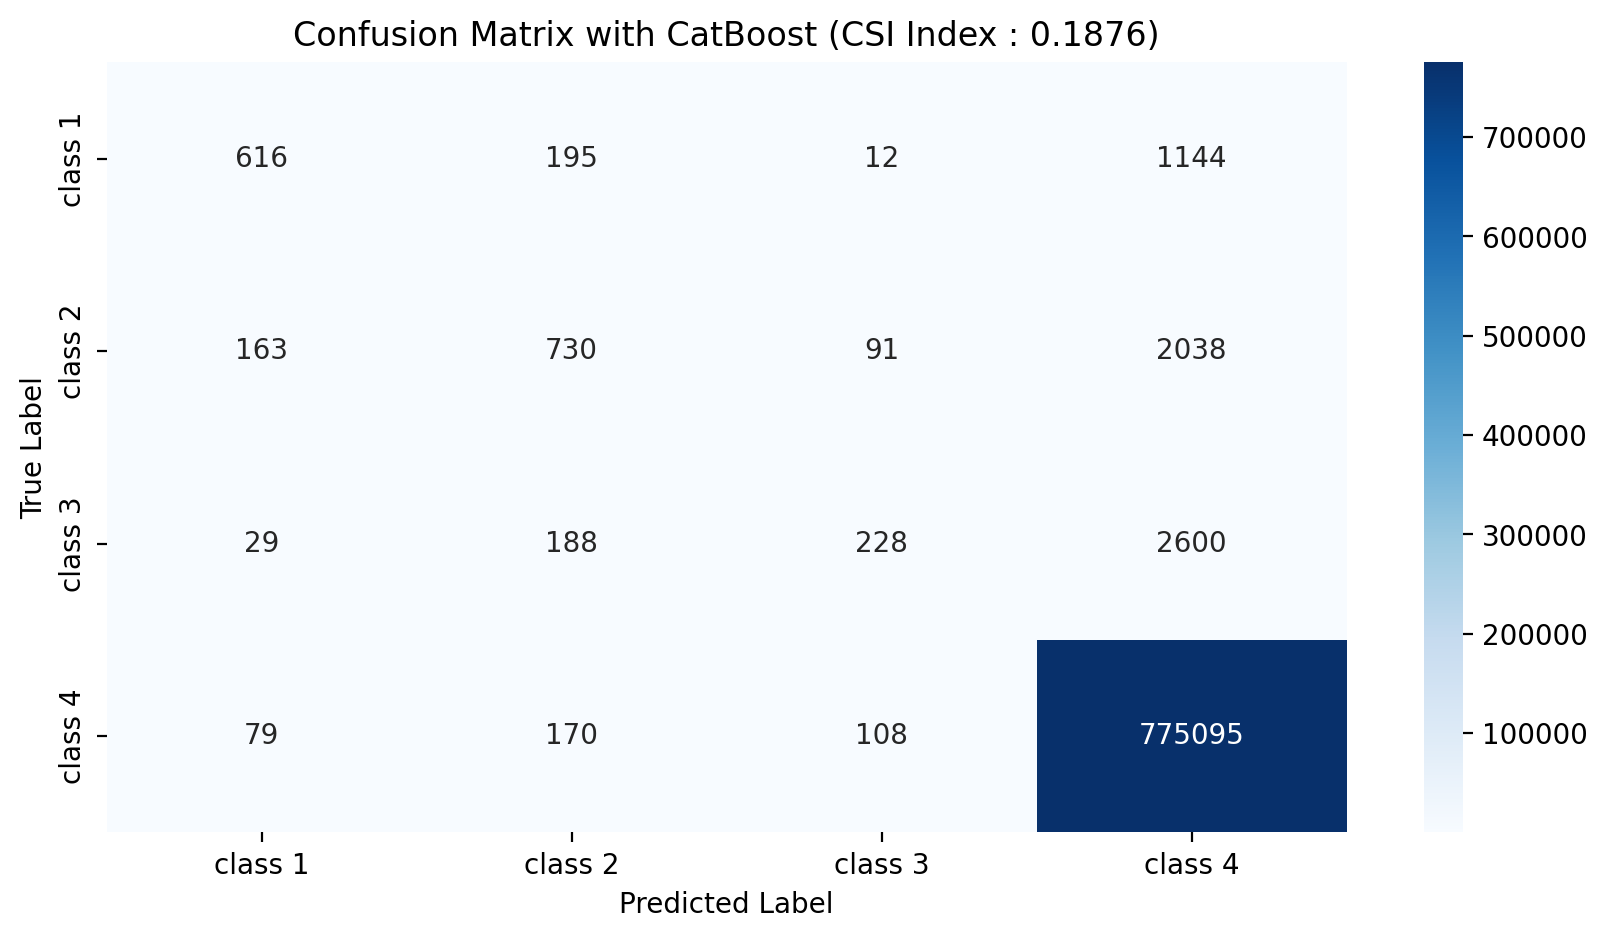

In [82]:
# Confusion Matrix 시각화

plt.figure(figsize=(10,5))

# target 컬럼 값들 unique_value에 선언
unique_value = np.unique(y_val_pred_cat, return_counts = False)

# Confusion Matrix에 label 표시하기 위해 "class" + value 합쳐준다
unique_value_list = []
for i, value in enumerate(unique_value):
    unique_value_list.append("class " + str(int(value)))


pred_labels = unique_value_list
sns.heatmap(cat_cm, 
            annot=True, 
            fmt="d", 
            cmap="Blues", 
            xticklabels = pred_labels, 
            yticklabels = pred_labels)

plt.title(f'Confusion Matrix with CatBoost (CSI Index : {np.round(csi_cat, 4)})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [70]:
y_train.value_counts()

class
4.0    2208397
3.0       8914
2.0       8842
1.0       5817
Name: count, dtype: int64

### 3-4. 하이퍼 파라미터 튜닝

#### 3-4-1. CatBoost 튜닝

In [83]:
# optuna sampling seed 고정
sampler = TPESampler(seed=42)

In [36]:
# https://practicaldatascience.co.uk/machine-learning/how-to-tune-a-catboostclassifier-model-with-optuna
# https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/002_configurations.html#configurations
# https://catboost.ai/en/docs/concepts/parameter-tuning#methods-for-hyperparameter-search-by-optuna

def objective_cat(trial):
    params = {
        # "loss_function":'MultiClass',
        "iterations": trial.suggest_int("iterations", 100, 1000),
        # "iterations" : trial.suggest_int('n_estimators', 500, 4000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        "depth": trial.suggest_int("depth", 3, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Poisson"]),
        "random_strength": trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        # "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        # "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        # "verbose": False
    }

    model = CatBoostClassifier(**params,
                               loss_function="MultiClass",
                               silent=True,
                               task_type="GPU",
                               random_state=42)

    model.fit(X_train_labeled, y_train)
    predictions = model.predict(X_val_labeled)
    csi = csi_index(y_val, predictions)

    return csi

In [37]:
study_cat = optuna.create_study(study_name="catboost", direction='maximize', pruner="MedianPruner", sampler=sampler)
study_cat.optimize(objective_cat, n_trials=100)

[I 2024-06-20 15:27:26,454] A new study created in memory with name: catboost
[I 2024-06-20 15:27:43,428] Trial 0 finished with value: 0.12850265399333416 and parameters: {'iterations': 437, 'learning_rate': 0.07969454818643935, 'depth': 8, 'l2_leaf_reg': 0.00969582664451522, 'bootstrap_type': 'Bayesian', 'random_strength': 3.3323645788192616e-08, 'bagging_temperature': 0.8661761457749352, 'od_type': 'Iter', 'od_wait': 10, 'min_data_in_leaf': 97}. Best is trial 0 with value: 0.12850265399333416.
[I 2024-06-20 15:27:51,306] Trial 1 finished with value: 0.0 and parameters: {'iterations': 850, 'learning_rate': 0.0026587543983272706, 'depth': 4, 'l2_leaf_reg': 6.8240955406304e-07, 'bootstrap_type': 'Poisson', 'random_strength': 7.71800699380605e-05, 'bagging_temperature': 0.2912291401980419, 'od_type': 'IncToDec', 'od_wait': 21, 'min_data_in_leaf': 37}. Best is trial 0 with value: 0.12850265399333416.
[I 2024-06-20 15:28:03,302] Trial 2 finished with value: 0.030605499735589636 and paramet

In [38]:
print("Best hyperparameters:", study_cat.best_params, sep="\n")
print("-----------------------------------------------------------------------------------------------------------------")
print("Best CSI Index:", study_cat.best_value, sep="\n")

Best hyperparameters:
{'iterations': 969, 'learning_rate': 0.0878195653278425, 'depth': 10, 'l2_leaf_reg': 0.11654433378634937, 'bootstrap_type': 'Bayesian', 'random_strength': 1.3986307347140839e-06, 'bagging_temperature': 0.5870994114781527, 'od_type': 'IncToDec', 'od_wait': 23, 'min_data_in_leaf': 9}
-----------------------------------------------------------------------------------------------------------------
Best CSI Index:
0.25162142685563293


In [47]:
# 하이퍼파라미터별 중요도를 확인할 수 있는 그래프
optuna.visualization.plot_param_importances(study_cat)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'cliponaxis': False,
              'hovertemplate': [random_strength (FloatDistribution):
                                0.000727617502335013<extra></extra>, l2_leaf_reg
                                (FloatDistribution):
                                0.0016466069500772331<extra></extra>, od_type
                                (CategoricalDistribution):
                                0.003049161142826468<extra></extra>,
                                bagging_temperature (FloatDistribution):
                                0.012851442534485832<extra></extra>,
                                min_data_in_leaf (IntDistribution):
                                0.018278405917158156<extra></extra>, od_wait
                                (IntDistribution):
                                0.040996698796146855<extra></extra>, depth
                                (IntDistribution):
                                0.09428634405916232<extra></extra>, iterations
                                (IntDistribution):
                                0.10174062493360612<extra></extra>, learning_rate
                                (FloatDistribution):
                                0.24178010825288918<extra></extra>, bootstrap_type
                                (CategoricalDistribution):
                                0.48464298991131266<extra></extra>],
              'name': 'Objective Value',
              'orientation': 'h',
              'text': [<0.01, <0.01, <0.01, 0.01, 0.02, 0.04, 0.09, 0.10, 0.24,
                       0.48],
              'textposition': 'outside',
              'type': 'bar',
              'x': [0.000727617502335013, 0.0016466069500772331,
                    0.003049161142826468, 0.012851442534485832,
                    0.018278405917158156, 0.040996698796146855,
                    0.09428634405916232, 0.10174062493360612, 0.24178010825288918,
                    0.48464298991131266],
              'y': [random_strength, l2_leaf_reg, od_type, bagging_temperature,
                    min_data_in_leaf, od_wait, depth, iterations, learning_rate,
                    bootstrap_type]}],
    'layout': {'template': '...',
               'title': {'text': 'Hyperparameter Importances'},
               'xaxis': {'title': {'text': 'Hyperparameter Importance'}},
               'yaxis': {'title': {'text': 'Hyperparameter'}}}
})

In [49]:
# 하이퍼파라미터 최적화 과정을 확인
optuna.visualization.plot_optimization_history(study_cat)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'mode': 'markers',
              'name': 'Objective Value',
              'type': 'scatter',
              'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                    18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
                    34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
                    50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65,
                    66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
                    82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97,
                    98, 99],
              'y': [0.12850265399333416, 0.0, 0.030605499735589636, 0.0,
                    0.017504376094023506, 0.0, 0.023342903507676944,
                    0.012149298597194389, 0.0, 0.02829862312322701,
                    0.07002974714923153, 0.06046684877079712, 0.02541739347121854,
                    0.15022724481021987, 0.06106491249844855, 0.13398249722667324,
                    0.04905989291495455, 0.06731246895181321, 0.0,
                    0.11493257453915626, 0.019, 0.0810575968222443,
                    0.07649530400395452, 0.10442959663449641, 0.04477611940298507,
                    0.04234446790016143, 0.0, 0.15621927236971483,
                    0.08052527254707631, 0.1495763232223996, 0.049396540997884784,
                    0.17262925753491792, 0.17063005638636922, 0.14970501474926254,
                    0.0, 0.021242034237161065, 0.0741246585547554, 0.0,
                    0.1728834355828221, 0.0706832298136646, 0.0,
                    0.18075980392156862, 0.12074494326591022, 0.15356220007382798,
                    0.22924231420963448, 0.20031699585466958, 0.03624813153961136,
                    0.21163186012627488, 0.005256241787122208, 0.1409371146732429,
                    0.09994125422235277, 0.017776664997496243, 0.21439844603617822,
                    0.1760520181572813, 0.2073704694721479, 0.18372575332438698,
                    0.08586592991129853, 0.0, 0.16304481276856966,
                    0.0988970132606271, 0.24036144578313254, 0.23447860156720915,
                    0.23626705300012074, 0.2298961603477421, 0.232317146644174,
                    0.23093629343629343, 0.23418102928769435, 0.2040247302703358,
                    0.2243613028211648, 0.0, 0.10841225626740947,
                    0.23595370147094286, 0.20416615909367766, 0.23075993717530507,
                    0.20089936801166747, 0.18595546855884512, 0.08314370733415018,
                    0.01837270341207349, 0.1112618724559023, 0.21423384168482207,
                    0.07370246500681284, 0.2216963960684383, 0.23299915448725692,
                    0.2168044747081712, 0.20311549227211878, 0.22578304510823557,
                    0.0, 0.25162142685563293, 0.22241127856101117,
                    0.2385486981677917, 0.10125306063661242, 0.24273833915873208,
                    0.23753771876885937, 0.23757106568283537, 0.24122542515981185,
                    0.19733789229454146, 0.21665702718334298, 0.09827049714161662,
                    0.20619059224957348, 0.0]},
             {'mode': 'lines',
              'name': 'Best Value',
              'type': 'scatter',
              'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                    18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
                    34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
                    50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65,
                    66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
                    82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97,
                    98, 99],
              'y': [0.12850265399333416, 0.12850265399333416, 0.12850265399333416,
                    0.12850265399333416, 0.12850265399333416, 0.12850265399333416,
                    0.1285

In [77]:
# 하이퍼파라미터 튜닝을 통해 나온 최적의 하이퍼 파라미터 best_params에 선언
best_params = study_cat.best_params

{'iterations': 969,
 'learning_rate': 0.0878195653278425,
 'depth': 10,
 'l2_leaf_reg': 0.11654433378634937,
 'bootstrap_type': 'Bayesian',
 'random_strength': 1.3986307347140839e-06,
 'bagging_temperature': 0.5870994114781527,
 'od_type': 'IncToDec',
 'od_wait': 23,
 'min_data_in_leaf': 9}

In [78]:
# CatBoost 모델을 돌릴 때 추가로 설정해주는 하이퍼파라미터
params_dict = {"loss_function" : "MultiClass",
               "verbose" : 0,
               "task_type" : "GPU",
               "devices" : "0",
               "random_state" : 42}

In [80]:
# best_params에 params_dict을 합쳐준다
def params(params):

    params_dict = {"loss_function" : "MultiClass",
                   "verbose" : 0,
                   "task_type" : "GPU",
                   "devices" : "0",
                   "random_state" : 42}
    
    for key, value in params_dict.items():
        params[key] = value
    
    return params

In [81]:
params(best_params)

{'iterations': 969,
 'learning_rate': 0.0878195653278425,
 'depth': 10,
 'l2_leaf_reg': 0.11654433378634937,
 'bootstrap_type': 'Bayesian',
 'random_strength': 1.3986307347140839e-06,
 'bagging_temperature': 0.5870994114781527,
 'od_type': 'IncToDec',
 'od_wait': 23,
 'min_data_in_leaf': 9,
 'loss_function': 'MultiClass',
 'verbose': 0,
 'task_type': 'GPU',
 'devices': '0',
 'random_state': 42}

In [83]:
# 튜닝한 하이퍼 파라미터를 바탕으로, CatBoostClassifier 선언
cat_optuna = CatBoostClassifier(**params(best_params))

In [85]:
cat_optuna.get_params()

{'iterations': 969,
 'learning_rate': 0.0878195653278425,
 'depth': 10,
 'l2_leaf_reg': 0.11654433378634937,
 'loss_function': 'MultiClass',
 'od_wait': 23,
 'od_type': 'IncToDec',
 'verbose': 0,
 'random_strength': 1.3986307347140839e-06,
 'bagging_temperature': 0.5870994114781527,
 'task_type': 'GPU',
 'devices': '0',
 'bootstrap_type': 'Bayesian',
 'random_state': 42,
 'min_data_in_leaf': 9}

#### 3-4. CatBoost 인코딩 X

In [84]:
# optuna sampling seed 고정
sampler = TPESampler(seed=42)

In [98]:
def objective_cat_no_enc(trial):
    params = {
        # "loss_function":'MultiClass',
        "iterations": trial.suggest_int("iterations", 900, 1000),
        # "iterations" : trial.suggest_int('n_estimators', 500, 4000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-2, 1e-1, log=True),
        "depth": trial.suggest_int("depth", 10, 12),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-1, 1.0, log=True),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Poisson"]),
        "random_strength": trial.suggest_float("random_strength", 1e-2, 1.0, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.4, 1.0),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 20, 30),
        # "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        # "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 10),
        # "verbose": False,
        "loss_function": trial.suggest_categorical("loss_function", ["MultiClass"]),
        "task_type": trial.suggest_categorical("task_type", ["GPU"]),
        "random_state":trial.suggest_int("random_state", 42, 42)
    }

    cat_features = ['month', 'stn_id', 're', 'dew_reached']

    model = CatBoostClassifier(**params, verbose=False)
                            #    loss_function="MultiClass",
                            #    silent=True,
                            #    task_type="GPU",
                            #    random_state=42)

    model.fit(X_train_no_enc, y_train, cat_features=cat_features)
    predictions = model.predict(X_val_no_enc)
    csi = csi_index(y_val, predictions)

    return csi

In [99]:
study_cat_no_enc = optuna.create_study(study_name="catboost_no_enc", direction='maximize', pruner="HyperbandPruner", sampler=sampler)
study_cat_no_enc.optimize(objective_cat_no_enc, n_trials=100)

[I 2024-06-23 07:23:28,955] A new study created in memory with name: catboost_no_enc
[I 2024-06-23 07:23:51,854] Trial 0 finished with value: 0.0 and parameters: {'iterations': 931, 'learning_rate': 0.0322530426717912, 'depth': 12, 'l2_leaf_reg': 0.17753837036522244, 'bootstrap_type': 'Poisson', 'random_strength': 0.02868113482103008, 'bagging_temperature': 0.44618794589727584, 'od_type': 'IncToDec', 'od_wait': 30, 'min_data_in_leaf': 9, 'loss_funtion': 'MultiClass', 'task_type': 'GPU', 'random_state': 42}. Best is trial 0 with value: 0.0.
[I 2024-06-23 07:26:24,681] Trial 1 finished with value: 0.27806031933767 and parameters: {'iterations': 963, 'learning_rate': 0.07438075634395301, 'depth': 12, 'l2_leaf_reg': 0.15366326576125022, 'bootstrap_type': 'Bayesian', 'random_strength': 0.4119839624605187, 'bagging_temperature': 0.937654779954096, 'od_type': 'IncToDec', 'od_wait': 22, 'min_data_in_leaf': 7, 'loss_funtion': 'MultiClass', 'task_type': 'GPU', 'random_state': 42}. Best is trial 

KeyboardInterrupt: 

In [177]:
print("Best hyperparameters:", study_cat_no_enc.best_params, sep="\n")
print("-----------------------------------------------------------------------------------------------------------------")
print("Best CSI Index:", study_cat_no_enc.best_value, sep="\n")

Best hyperparameters:
{'iterations': 927, 'learning_rate': 0.09884918112580136, 'depth': 10, 'l2_leaf_reg': 0.006029773218917519, 'bootstrap_type': 'Bayesian', 'random_strength': 0.00044516435580350196, 'bagging_temperature': 0.06321863987627019, 'od_type': 'Iter', 'od_wait': 18, 'min_data_in_leaf': 86}
-----------------------------------------------------------------------------------------------------------------
Best CSI Index:
0.2587320574162679


In [178]:
# 하이퍼파라미터별 중요도를 확인할 수 있는 그래프
optuna.visualization.plot_param_importances(study_cat_no_enc)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'cliponaxis': False,
              'hovertemplate': [random_strength (FloatDistribution):
                                0.0001897742509499148<extra></extra>, l2_leaf_reg
                                (FloatDistribution):
                                0.000256762554585744<extra></extra>, od_type
                                (CategoricalDistribution):
                                0.0013887726822324447<extra></extra>,
                                bagging_temperature (FloatDistribution):
                                0.003906969648397853<extra></extra>, od_wait
                                (IntDistribution):
                                0.005988051793351469<extra></extra>, iterations
                                (IntDistribution):
                                0.010486613375497998<extra></extra>,
                                min_data_in_leaf (IntDistribution):
                                0.01629313334389075<extra></extra>, depth
                                (IntDistribution):
                                0.02788166709714984<extra></extra>, learning_rate
                                (FloatDistribution):
                                0.19767460787623292<extra></extra>, bootstrap_type
                                (CategoricalDistribution):
                                0.7359336473777108<extra></extra>],
              'name': 'Objective Value',
              'orientation': 'h',
              'text': [<0.01, <0.01, <0.01, <0.01, <0.01, 0.01, 0.02, 0.03, 0.20,
                       0.74],
              'textposition': 'outside',
              'type': 'bar',
              'x': [0.0001897742509499148, 0.000256762554585744,
                    0.0013887726822324447, 0.003906969648397853,
                    0.005988051793351469, 0.010486613375497998,
                    0.01629313334389075, 0.02788166709714984, 0.19767460787623292,
                    0.7359336473777108],
              'y': [random_strength, l2_leaf_reg, od_type, bagging_temperature,
                    od_wait, iterations, min_data_in_leaf, depth, learning_rate,
                    bootstrap_type]}],
    'layout': {'template': '...',
               'title': {'text': 'Hyperparameter Importances'},
               'xaxis': {'title': {'text': 'Hyperparameter Importance'}},
               'yaxis': {'title': {'text': 'Hyperparameter'}}}
})

In [179]:
# 하이퍼파라미터 최적화 과정을 확인
optuna.visualization.plot_optimization_history(study_cat_no_enc)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'mode': 'markers',
              'name': 'Objective Value',
              'type': 'scatter',
              'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                    18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
                    34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
                    50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65,
                    66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
                    82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97,
                    98, 99],
              'y': [0.0, 0.023342903507676944, 0.012149298597194389, 0.0,
                    0.02829862312322701, 0.003986841419876508, 0.0, 0.0, 0.0,
                    0.034253326761951704, 0.04224652087475149, 0.04114356743318832,
                    0.04277542899776175, 0.0347058091802463, 0.12255203842837788,
                    0.14013287401574803, 0.13677212852394435, 0.2116177540625758,
                    0.17183098591549295, 0.1435270887325682, 0.07817243472981178,
                    0.12756489493201484, 0.15966283899340336, 0.06799003455758258,
                    0.09423434593924365, 0.08975560521952275, 0.1370516029078775,
                    0.2086374695863747, 0.21046878795239252, 0.0,
                    0.05438028870084619, 0.1757583170254403, 0.20450944546008532,
                    0.1790953545232274, 0.016143161056188213, 0.19450522732798445,
                    0.14241676942046855, 0.0, 0.03598555597061387, 0.0,
                    0.0509867028034217, 0.20368797767802985, 0.20559270516717326,
                    0.15075562108367122, 0.17060335332272672, 0.0,
                    0.13626265119723524, 0.1276885043263288, 0.15592387968078575,
                    0.12527825871877318, 0.0, 0.22854387656702024,
                    0.2009254749147589, 0.20514069923254963, 0.08187013702403084,
                    0.20009737098344693, 0.20251785498123714, 0.19288595526219288,
                    0.11170212765957446, 0.10615422639644093, 0.021630615640599003,
                    0.2109858130229174, 0.08344095279093126, 0.17672994488671157,
                    0.0059074912016088485, 0.11122561648877438,
                    0.17411534223092934, 0.207303712720633, 0.0,
                    0.08137555328566565, 0.08181818181818182, 0.18876239441792142,
                    0.09760386898219389, 0.2587320574162679, 0.22713009896210476,
                    0.09783003120690907, 0.2273002055374199, 0.19773667559016792,
                    0.07106263427532639, 0.234168071273778, 0.055781391147244806,
                    0.22721236267053, 0.2225042301184433, 0.22042945529540217,
                    0.21988643228222787, 0.1732418524871355, 0.21506550218340612,
                    0.0, 0.1577263779527559, 0.21304294926390072,
                    0.07059671028935047, 0.2114334263866974, 0.21324245374878287,
                    0.07924417753039402, 0.23167791706846674, 0.2352727712592234,
                    0.2318560560318802, 0.22914402994084268, 0.20177896917265747,
                    0.0]},
             {'mode': 'lines',
              'name': 'Best Value',
              'type': 'scatter',
              'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                    18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
                    34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
                    50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65,
                    66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
                    82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97,
                    98, 99],
              'y': [0.0, 0.023342903507676944, 0.023342903507676944,
                    0.023342903507676944, 0.02829862312322701, 0.02829862312322701,
                    0.0282986231

In [181]:
# 하이퍼파라미터 튜닝을 통해 나온 최적의 하이퍼 파라미터 best_params에 선언
best_params_no_enc = study_cat_no_enc.best_params

In [182]:
best_params_no_enc

{'iterations': 927,
 'learning_rate': 0.09884918112580136,
 'depth': 10,
 'l2_leaf_reg': 0.006029773218917519,
 'bootstrap_type': 'Bayesian',
 'random_strength': 0.00044516435580350196,
 'bagging_temperature': 0.06321863987627019,
 'od_type': 'Iter',
 'od_wait': 18,
 'min_data_in_leaf': 86}

In [184]:
# CatBoost 모델을 돌릴 때 추가로 설정해주는 하이퍼파라미터
params_dict = {"loss_function" : "MultiClass",
               "verbose" : 0,
               "task_type" : "GPU",
               "devices" : "0",
               "random_state" : 42}

In [185]:
params(best_params_no_enc)

{'iterations': 927,
 'learning_rate': 0.09884918112580136,
 'depth': 10,
 'l2_leaf_reg': 0.006029773218917519,
 'bootstrap_type': 'Bayesian',
 'random_strength': 0.00044516435580350196,
 'bagging_temperature': 0.06321863987627019,
 'od_type': 'Iter',
 'od_wait': 18,
 'min_data_in_leaf': 86,
 'loss_function': 'MultiClass',
 'verbose': 0,
 'task_type': 'GPU',
 'devices': '0',
 'random_state': 42}

In [106]:
# 튜닝한 하이퍼 파라미터를 바탕으로, CatBoostClassifier 선언
# cat_optuna_no_enc = CatBoostClassifier(**params(best_params_no_enc))
best_params_no_enc = {'iterations': 930, 
                      'learning_rate': 0.09983669530310456, 
                      'depth': 12, 
                      'l2_leaf_reg': 0.1147068286463238, 
                      'bootstrap_type': 'Bayesian', 
                      'random_strength': 0.9568085992921923, 
                      'bagging_temperature': 0.9638236103673785, 
                      'od_type': 'IncToDec', 
                      'od_wait': 22, 
                      'min_data_in_leaf': 6, 
                      'loss_function': 'MultiClass', 
                      'task_type': 'GPU', 
                      'random_state': 42}

cat_optuna_no_enc = CatBoostClassifier(**best_params_no_enc)

In [107]:
cat_optuna_no_enc.get_params()

{'iterations': 930,
 'learning_rate': 0.09983669530310456,
 'depth': 12,
 'l2_leaf_reg': 0.1147068286463238,
 'loss_function': 'MultiClass',
 'od_wait': 22,
 'od_type': 'IncToDec',
 'random_strength': 0.9568085992921923,
 'bagging_temperature': 0.9638236103673785,
 'task_type': 'GPU',
 'bootstrap_type': 'Bayesian',
 'random_state': 42,
 'min_data_in_leaf': 6}

#### 3-4-2. 모델 비교

In [188]:

models_tuned = [
    ("Decision Tree", DecisionTreeClassifier(random_state=42)),
    ("CatBoost", CatBoostClassifier(**params_dict)),
    ("CatBoost_tuned", cat_optuna),
    ("CatBoost_tuned_no_enc", cat_optuna_no_enc),
]

In [189]:
model_comparison(models_tuned, X_train_labeled, y_train, X_val_labeled, y_val, when="After")


======== Models After Hyper Parameter Tuning ========



,Model,Accuracy,Precision,Recall,F1 Score,CSI Index
0,CatBoost_tuned_no_enc,0.9917,0.9893,0.9917,0.9897,0.2585
1,CatBoost_tuned,0.9917,0.9892,0.9917,0.9896,0.2516
2,Decision Tree,0.9875,0.9884,0.9875,0.9879,0.2378
3,CatBoost,0.9911,0.9881,0.9911,0.9885,0.1947


#### 3-4-3. 모델 학습 (튜닝한 CatBoost)

In [90]:
cat_optuna.fit(X_train_labeled, y_train)

In [91]:
y_val_pred = cat_optuna.predict(X_val_labeled)

In [98]:
cat_cm = confusion_matrix(y_val, y_val_pred)
print(cat_cm)

csi_cat = csi_index(y_val, y_val_pred)
csi_cat

[[   809    229      8    905]
 [   191    929    119   1755]
 [    21    208    367   2389]
 [    55    166    167 740395]]


0.25306564077903343

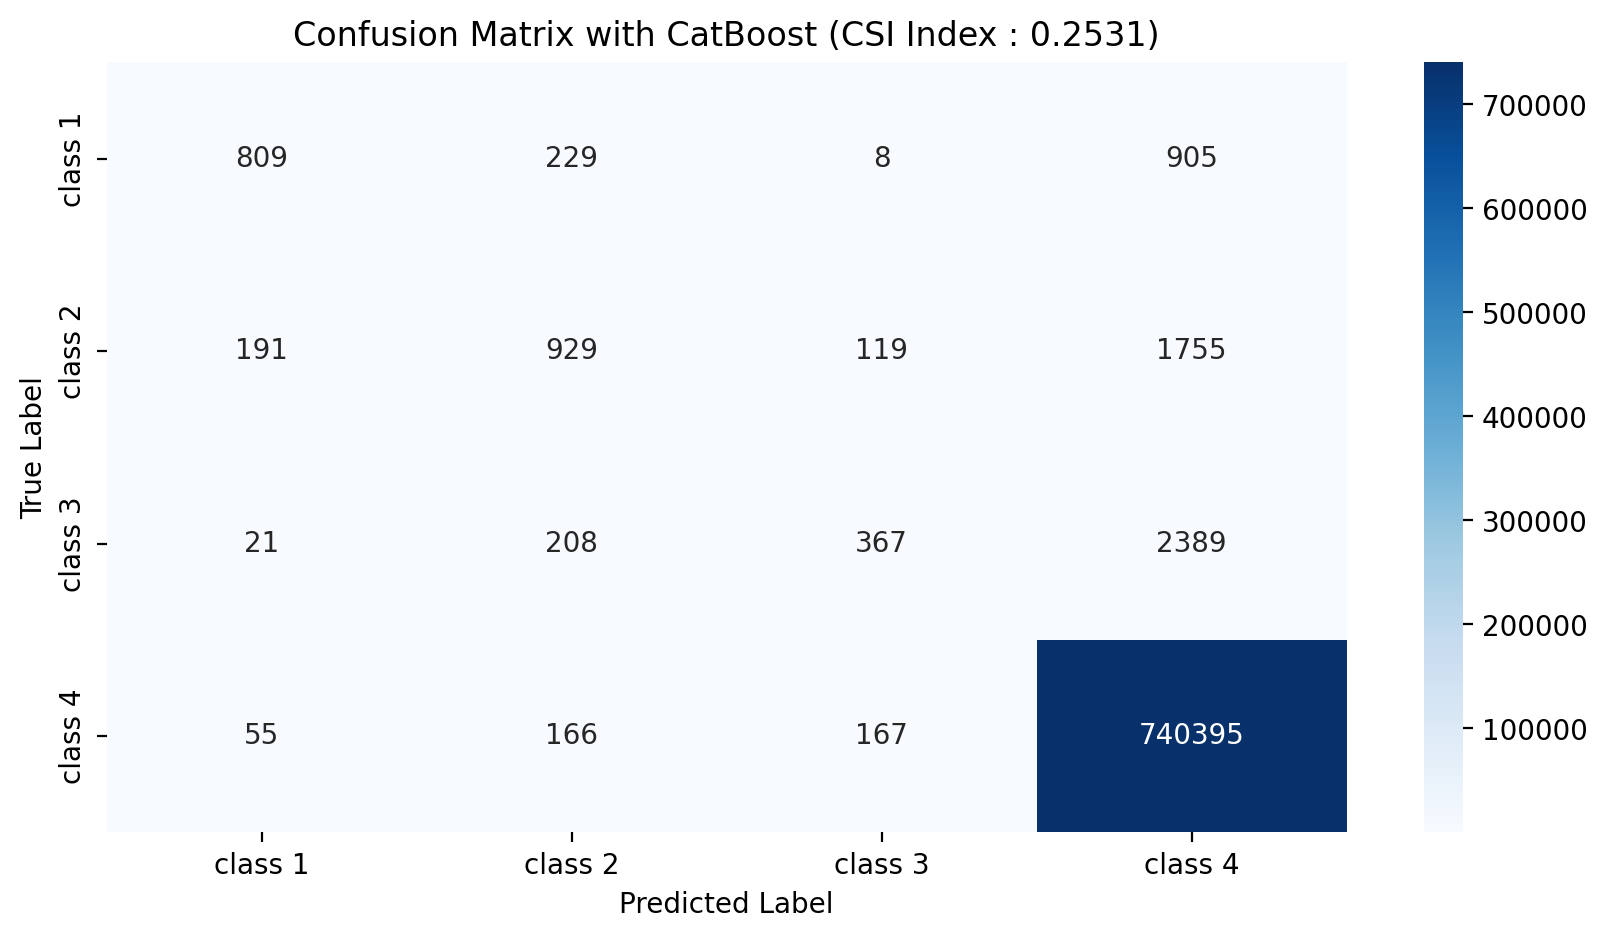

In [100]:
# Confusion Matrix 시각화

plt.figure(figsize=(10,5))

# target 컬럼 값들 unique_value에 선언
unique_value = np.unique(y_val_pred, return_counts = False)

# Confusion Matrix에 label 표시하기 위해 "class" + value 합쳐준다
unique_value_list = []
for i, value in enumerate(unique_value):
    unique_value_list.append("class " + str(int(value)))


pred_labels = unique_value_list
sns.heatmap(cat_cm, 
            annot=True, 
            fmt="d", 
            cmap="Blues", 
            xticklabels = pred_labels, 
            yticklabels = pred_labels)

plt.title(f'Confusion Matrix with CatBoost (CSI Index : {np.round(csi_cat, 4)})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### 인코딩 안함

In [111]:
cat_optuna_no_enc.fit(X_train_no_enc, y_train, cat_features=cat_features)

0:	learn: 1.1100039	total: 250ms	remaining: 3m 52s
1:	learn: 0.9239873	total: 394ms	remaining: 3m 2s
2:	learn: 0.7861073	total: 536ms	remaining: 2m 45s
3:	learn: 0.6785817	total: 677ms	remaining: 2m 36s
4:	learn: 0.5919626	total: 815ms	remaining: 2m 30s
5:	learn: 0.5206203	total: 947ms	remaining: 2m 25s
6:	learn: 0.4609207	total: 1.08s	remaining: 2m 23s
7:	learn: 0.4103362	total: 1.21s	remaining: 2m 19s
8:	learn: 0.3670544	total: 1.35s	remaining: 2m 17s
9:	learn: 0.3297740	total: 1.49s	remaining: 2m 16s
10:	learn: 0.2974231	total: 1.62s	remaining: 2m 15s
11:	learn: 0.2691783	total: 1.76s	remaining: 2m 14s
12:	learn: 0.2444662	total: 1.9s	remaining: 2m 13s
13:	learn: 0.2227580	total: 2.04s	remaining: 2m 13s
14:	learn: 0.2036082	total: 2.18s	remaining: 2m 13s
15:	learn: 0.1866948	total: 2.32s	remaining: 2m 12s
16:	learn: 0.1716895	total: 2.46s	remaining: 2m 12s
17:	learn: 0.1583690	total: 2.61s	remaining: 2m 12s
18:	learn: 0.1465562	total: 2.75s	remaining: 2m 11s
19:	learn: 0.1359761	tot

In [112]:
y_val_pred_no_enc = cat_optuna_no_enc.predict(X_val_no_enc)

In [113]:
cat_cm = confusion_matrix(y_val, y_val_pred_no_enc)
print(cat_cm)

csi_cat = csi_index(y_val, y_val_pred_no_enc)
csi_cat

[[   937    262     27    741]
 [   223   1057    188   1554]
 [    29    254    505   2257]
 [    66    162    262 774962]]


0.2931722196152041

In [191]:
# y_val_pred_no_enc = cat_optuna_no_enc.predict(X_val)

In [114]:
# cat_cm_no_enc = confusion_matrix(y_val, y_val_pred_no_enc)
# print(cat_cm_no_enc)

# csi_cat_no_enc = csi_index(y_val, y_val_pred_no_enc)
# # csi_cat_no_enc

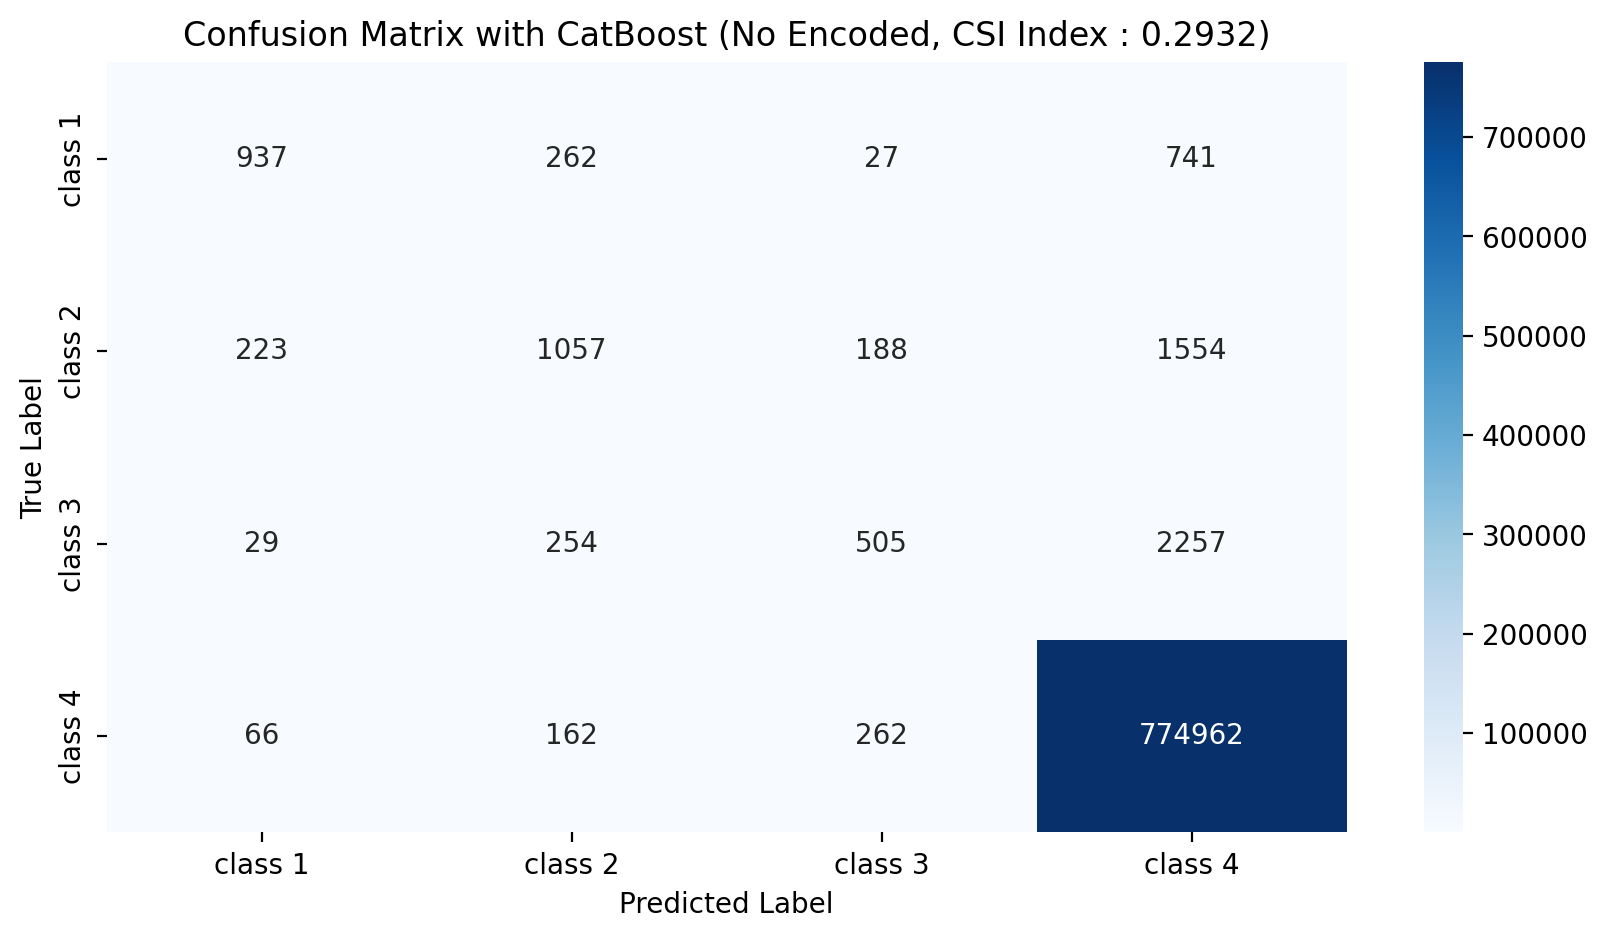

In [116]:
# Confusion Matrix 시각화

plt.figure(figsize=(10,5))

# target 컬럼 값들 unique_value에 선언
unique_value = np.unique(y_val_pred_no_enc, return_counts = False)

# Confusion Matrix에 label 표시하기 위해 "class" + value 합쳐준다
unique_value_list = []
for i, value in enumerate(unique_value):
    unique_value_list.append("class " + str(int(value)))


pred_labels = unique_value_list
sns.heatmap(cat_cm, 
            annot=True, 
            fmt="d", 
            cmap="Blues", 
            xticklabels = pred_labels, 
            yticklabels = pred_labels)

plt.title(f'Confusion Matrix with CatBoost (No Encoded, CSI Index : {np.round(csi_cat, 4)})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### 3-4-4. 모델 저장 (pickle)

In [117]:
# 전처리 마친 데이터셋 저장할 경로 설정하는 함수

def save_pickle_path(model_name):
        
    # 작업 디렉토리 origin_dir에 선언
    origin_dir = os.getcwd()

    # ".." : 상위 디렉토리로 이동
    os.chdir("..")

    # pickle 저장 이름 설정
    save_pickle = model_name + ".pkl"
    # 전처리 거친 데이터셋 저장 경로 설정
    pickle_save_path = os.path.join(os.getcwd(), "fog_data", save_pickle)
    
    
    # 운영체제가 윈도우일 경우, "\\"를 "/"로 바꿔줘야 한다
    if os.name == "nt":
        pickle_save_path = pickle_save_path.replace("\\", "/")

    # # origin_dir로 경로 다시 변경 (초기화)
    os.chdir(origin_dir)

    return pickle_save_path

In [104]:
save_pickle_path("cat_optuna")

'c:/Users/aryij/Documents/DataStudy/fog_data/cat_optuna.pkl'

In [118]:
save_pickle_path("cat_optuna_no_enc")

'c:/Users/aryij/Documents/DataStudy/fog_data/cat_optuna_no_enc.pkl'

In [105]:
# 하이퍼파라미터 튜닝 거친 모델 pickle 저장
with open(file=save_pickle_path("cat_optuna"), mode='wb') as f:
    pickle.dump(cat_optuna, f)

In [119]:
# 하이퍼파라미터 튜닝 거친 모델 pickle 저장
with open(file=save_pickle_path("cat_optuna_no_enc"), mode='wb') as f:
    pickle.dump(cat_optuna_no_enc, f)

In [107]:
# pickle로 저장한 모델 불러오기
with open(file=save_pickle_path("cat_optuna"), mode="rb") as f:
    # loaded_model 이라는 이름에 모델 불러온다
    loaded_model = pickle.load(f)

In [121]:
X_train_no_enc

,month,time,stn_id,ta,ts,temp_diff,hm,re,ws10_deg,ws10_ms,sun10,dew_reached
0,4,15,B,10.3,13.8,-3.5,59.3,0,112.4,2.2,0.14,0
1,4,9,B,10.1,18.3,-8.2,54.4,0,273.6,4.8,0.31,0
2,3,10,D,18.1,20.1,-2.0,47.0,0,158.2,3.1,0.22,0
3,7,23,A,24.0,24.3,-0.3,81.8,0,238.0,0.9,0.00,0
4,1,0,D,-3.8,-3.0,-0.8,81.6,0,303.7,1.0,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2210951,3,15,A,3.7,9.2,-5.5,50.9,0,291.9,4.7,0.06,0
2210952,3,0,A,10.4,7.2,3.2,64.0,0,120.0,1.2,0.00,0
2210953,8,2,D,25.4,25.3,0.1,92.7,0,239.4,3.4,0.00,0
2210954,11,21,A,11.4,5.5,5.9,83.4,0,184.6,0.7,0.00,1


In [120]:
X_test

,month,time,stn_id,ta,ts,temp_diff,hm,re,ws10_deg,ws10_ms,sun10,dew_reached
0,1,0,A,-2.5,-1.6,-0.9,87.5,0,329.5,0.6,0.0,0
1,1,0,A,-2.5,-1.6,-0.9,88.2,0,321.8,1.2,0.0,0
2,1,0,A,-2.5,-1.7,-0.8,88.6,0,0.4,0.4,0.0,0
3,1,0,A,-2.6,-1.6,-1.0,88.7,0,323.6,0.7,0.0,0
4,1,0,A,-2.6,-1.6,-1.0,89.0,0,208.4,0.2,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
262795,12,23,E,4.5,1.9,2.6,71.3,0,338.8,6.1,0.0,0
262796,12,23,E,4.6,1.9,2.7,71.4,0,335.2,5.8,0.0,0
262797,12,23,E,4.5,1.8,2.7,72.1,0,337.1,5.3,0.0,0
262798,12,23,E,4.3,1.4,2.9,72.5,0,322.0,3.7,0.0,0


In [122]:
y_test_pred = cat_optuna_no_enc.predict(X_test)

In [132]:
y_test_pred_df = pd.DataFrame(y_test_pred)

In [135]:
y_test_pred_df.to_csv("C:/Users/aryij/Documents/DataStudy/weather-contest/data")

PermissionError: [Errno 13] Permission denied: 'C:/Users/aryij/Documents/DataStudy/weather-contest/data'